In [1]:
%env CUDA_LAUNCH_BLOCKING=0
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_LAUNCH_BLOCKING=0
env: CUDA_VISIBLE_DEVICES=0


Install Real-ESRGAN from [repository](https://github.com/xinntao/Real-ESRGAN.git)

Perform super-resolution for the training set with synthetic data using a similar command
```
for f in ANGRER DISGUST FEAR HAPPINESS SADNESS SURPRISE; do echo $f; CUDA_VISIBLE_DEVICES=0 python3 inference_realesrgan.py -n RealESRGAN_x4plus -i /home/HDD6TB/datasets/emotions/ABAW/eccv_4/training_set_synthetic_images/$f --face_enhance -s 2 -o /home/HDD6TB/datasets/emotions/ABAW/eccv_4/SR/training_set_synthetic_images/$f; done;
```

In [2]:
import pathlib
DATA_DIR = pathlib.Path('/home/HDD6TB/datasets/emotions/ABAW/eccv_4')
#train_dir=DATA_DIR / 'training_set_synthetic_images'
train_dir=DATA_DIR / 'SR/training_set_synthetic_images'
test_dir=DATA_DIR / 'validation_set_real_images'
final_test_dir=DATA_DIR / 'lsd_test_data'
print(train_dir,test_dir,final_test_dir)

/home/HDD6TB/datasets/emotions/ABAW/eccv_4/SR/training_set_synthetic_images /home/HDD6TB/datasets/emotions/ABAW/eccv_4/validation_set_real_images /home/HDD6TB/datasets/emotions/ABAW/eccv_4/lsd_test_data


In [3]:
import os
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn import svm,metrics,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score,roc_auc_score,average_precision_score
import mord

from collections import defaultdict
import os
import glob
import random
import numpy as np
from tqdm import tqdm
import time
import pickle
import pandas as pd
import random
import csv  
import matplotlib.pyplot as plt

In [4]:
def one_hot_transfer(label,class_num):
    return np.eye(class_num)[label]

def metric_for_Exp(gt,pred,class_num=6):
    # compute_acc
    acc = accuracy_score(gt,pred)
    # compute_F1
    gt = one_hot_transfer(gt,class_num)
    pred = one_hot_transfer(pred,class_num)
    F1 = []
    for i in range(class_num):
        gt_ = gt[:,i]
        pred_ = pred[:,i]
        F1.append(f1_score(gt_.flatten(), pred_))
    F1_mean = np.mean(F1)
    return F1_mean,acc,F1

# Train

In [5]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm


print(f"Torch: {torch.__version__}")

Torch: 1.7.1+cu110


In [6]:
# Training settings
batch_size = 64 #48# 96# 32 #40 #32 #16 #8 #
epochs = 8
lr = 3e-5
gamma = 0.7
seed = 42
device = 'cuda'
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [7]:
if False:
    PATH='enet_b2_8.pt'
    #PATH='enet_b2_7.pt'
    IMG_SIZE=260 #224 #
else:
    #PATH='enet_b0_7.pt'
    #PATH='enet_b0_8_best_afew.pt'
    #PATH='enet_b0_8_best_vgaf.pt'
    
    PATH='enet_b0_8_va_mtl.pt'
    IMG_SIZE=224

train_transforms = transforms.Compose(
    [
        #transforms.RandomRotation(degrees=10),
        #transforms.RandomResizedCrop(IMG_SIZE),
        #transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)

In [8]:
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

print(train_dir,test_dir)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs) 

print(len(train_dataset), len(test_dataset))

/home/HDD6TB/datasets/emotions/ABAW/eccv_4/SR/training_set_synthetic_images /home/HDD6TB/datasets/emotions/ABAW/eccv_4/validation_set_real_images
277251 4670


In [9]:
class_to_idx=train_dataset.class_to_idx
print(class_to_idx)
idx_to_class={idx:cls for cls,idx in class_to_idx.items()}
print(idx_to_class)

{'ANGRER': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPINESS': 3, 'SADNESS': 4, 'SURPRISE': 5}
{0: 'ANGRER', 1: 'DISGUST', 2: 'FEAR', 3: 'HAPPINESS', 4: 'SADNESS', 5: 'SURPRISE'}


In [10]:
(unique, counts) = np.unique(train_dataset.targets, return_counts=True)
cw=1/counts
#cw/=cw.min()
cw*=counts.mean()
class_weights = {i:cwi for i,cwi in zip(unique,cw)}
print(counts, class_weights.values())

[ 18286  15150  10923  73285 144631  14976] dict_values([2.5269878595646946, 3.0500660066006597, 4.230385425249474, 0.6305314866616634, 0.31949236332459846, 3.0855034722222223])


In [11]:
num_classes=len(train_dataset.classes)
print(num_classes)

6


In [12]:
""" Label smooth """
def label_smooth(target, n_classes: int, label_smoothing=0.1):
    # convert to one-hot
    batch_size = target.size(0)
    target = torch.unsqueeze(target, 1)
    soft_target = torch.zeros((batch_size, n_classes), device=target.device)
    soft_target.scatter_(1, target, 1)
    # label smoothing
    soft_target = soft_target * (1 - label_smoothing) + label_smoothing / n_classes
    return soft_target

def cross_entropy_loss_with_soft_target(pred, soft_target):
    #logsoftmax = nn.LogSoftmax(dim=-1)
    return torch.mean(torch.sum(- weights*soft_target * torch.nn.functional.log_softmax(pred, -1), 1))

def cross_entropy_with_label_smoothing(pred, target):
    soft_target = label_smooth(target, pred.size(1)) #num_classes) #
    return cross_entropy_loss_with_soft_target(pred, soft_target)


In [13]:
# loss function
weights = torch.FloatTensor(list(class_weights.values())).cuda()
if False:
    criterion = nn.CrossEntropyLoss(weight=weights)
    #criterion = nn.CrossEntropyLoss()
else:
    criterion=cross_entropy_with_label_smoothing

In [14]:
import sys
sys.path.append('../affectnet')
from robust_optimization import RobustOptimizer

import copy
def train(model,n_epochs=epochs, learningrate=lr, robust=False, op=optim.Adam, need_train_acc=True):
    # optimizer
    if robust:
        optimizer = RobustOptimizer(filter(lambda p: p.requires_grad, model.parameters()), op, lr=learningrate)
        #print(optimizer)
    else:
        optimizer=op(filter(lambda p: p.requires_grad, model.parameters()), lr=learningrate)
    # scheduler
    #scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    best_acc=0
    best_model=None
    for epoch in range(n_epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        model.train()
        if True:
            for data, label in tqdm(train_loader):
                data = data.to(device)
                label = label.to(device)

                output = model(data)
                loss = criterion(output, label)

                if use_sam:
                    #optimizer.zero_grad()
                    loss.backward()
                    optimizer.first_step(zero_grad=True)

                    # second forward-backward pass
                    output = model(data)
                    loss = criterion(output, label)
                    loss.backward()
                    optimizer.second_step(zero_grad=True)
                else:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                if need_train_acc:
                    acc = (output.argmax(dim=1) == label).float().mean()
                    epoch_accuracy += acc / len(train_loader)
                epoch_loss += loss / len(train_loader)

        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            gt,pred=[],[]
            for data, label in test_loader:
                data = data.to(device)
                
                val_output = model(data)
                if False:
                    label = label.to(device)
                    acc = (val_output.argmax(dim=1) == label).float().mean()
                    epoch_val_accuracy += acc / len(test_loader)
                else:
                    gt.append(label)
                    pred.append(val_output.argmax(dim=1).cpu())

        gt=np.concatenate(gt)
        pred=np.concatenate(pred)
        print(gt.shape,pred.shape)
        epoch_val_F1,epoch_val_accuracy,_=metric_for_Exp(gt,pred)
        if need_train_acc:
            print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_acc: {epoch_val_accuracy:.4f} - val_f1: {epoch_val_F1:.4f}\n")
        else:
            #print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n")
            print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - val_acc: {epoch_val_accuracy:.4f} - val_f1: {epoch_val_F1:.4f}\n")
        #epoch_val_F1=epoch_val_accuracy
        if best_acc<epoch_val_F1:
            best_acc=epoch_val_F1
            best_model=copy.deepcopy(model.state_dict())
        #scheduler.step()
    
    if best_model is not None:
        model.load_state_dict(best_model)
        print(f"Best acc:{best_acc}")
        model.eval()
        with torch.no_grad():
            epoch_val_accuracy = 0
            for data, label in test_loader:
                data = data.to(device)
                label = label.to(device)

                val_output = model(data)
                
                acc = (val_output.argmax(dim=1) == label).float().mean()
                epoch_val_accuracy += acc / len(test_loader)

        print(
            f"val_acc: {epoch_val_accuracy:.4f}\n"
        )
    else:
        print(f"No best model Best acc:{best_acc}")

# Pre-trained CNN 

In [15]:
print(PATH)
model = torch.load('../../models/affectnet_emotions/'+PATH)
print(model)

enet_b0_8_va_mtl.pt
EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): 

In [16]:
import copy
pretrained_model=copy.deepcopy(model)

## Test

In [17]:
y_val,y_scores_val_pretrained=[],[]
pretrained_model.eval()

d=test_dir
#d=DATA_DIR / 'SR/validation_set_real_images'

print(d,test_transforms)
for class_name in tqdm(os.listdir(d)):
    if class_name in class_to_idx:
        class_dir=d / class_name
        y=class_to_idx[class_name]
        imgs=[]
        for img_name in os.listdir(class_dir):
            filepath=class_dir / img_name
            if str(filepath).lower().endswith('.jpg'):
                img = Image.open(filepath)
                if img.size:
                    img_tensor = test_transforms(img)
                    imgs.append(img_tensor)
                    y_val.append(y)
                    if len(imgs)>32:        
                        scores = model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        if len(y_scores_val_pretrained)==0:
                            y_scores_val_pretrained=scores
                        else:
                            y_scores_val_pretrained=np.concatenate((y_scores_val_pretrained,scores),axis=0)
                        imgs=[]
        if len(imgs)>0:        
            scores = model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            if len(y_scores_val_pretrained)==0:
                y_scores_val_pretrained=scores
            else:
                y_scores_val_pretrained=np.concatenate((y_scores_val_pretrained,scores),axis=0)
            imgs=[]
y_val=np.array(y_val)
print(y_scores_val_pretrained.shape,y_val.shape)

/home/HDD6TB/datasets/emotions/ABAW/eccv_4/validation_set_real_images Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


  0%|          | 0/6 [00:00<?, ?it/s]

(4670, 10) (4670,)


In [20]:
NUM_EMOTIONS=min(8,pretrained_model.classifier.out_features) #pretrained_model.classifier[0].out_features
if NUM_EMOTIONS==7:
    orig_score_to_emotion={0: 'ANGRER', 1: 'DISGUST', 2: 'FEAR', 3: 'HAPPINESS', 4: 'Neutral', 5: 'SADNESS', 6: 'SURPRISE'}
else:
    orig_score_to_emotion={0: 'ANGRER', 1: 'Contempt', 2: 'DISGUST', 3: 'FEAR', 4: 'HAPPINESS', 5: 'Neutral', 6: 'SADNESS', 7: 'SURPRISE'}
print(NUM_EMOTIONS,orig_score_to_emotion,class_to_idx)

indices=np.array([i for i,emotion in orig_score_to_emotion.items() if emotion in class_to_idx])
print(indices)

8 {0: 'ANGRER', 1: 'Contempt', 2: 'DISGUST', 3: 'FEAR', 4: 'HAPPINESS', 5: 'Neutral', 6: 'SADNESS', 7: 'SURPRISE'} {'ANGRER': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPINESS': 3, 'SADNESS': 4, 'SURPRISE': 5}
[0 2 3 4 6 7]


In [21]:
y_scores_val_filtered=y_scores_val_pretrained[:, indices]
print(y_scores_val_filtered.shape)
y_pred_pretrained=np.argmax(y_scores_val_filtered,axis=1)
acc=100.0*(y_val==y_pred_pretrained).sum()/len(y_val)
print(acc)
print(metric_for_Exp(gt=y_val,pred=y_pred_pretrained))

(4670, 6)
68.82226980728052
(0.6094158203574996, 0.6882226980728051, [0.7262569832402234, 0.5073313782991203, 0.23831775700934577, 0.8456375838926175, 0.7091004734350342, 0.6298507462686567])


enet0_mtl
(0.6094158203574996, 0.6882226980728051, [0.7262569832402234, 0.5073313782991203, 0.23831775700934577, 0.8456375838926175, 0.7091004734350342, 0.6298507462686567])

enet0_vgaf
66.59528907922912
(0.5972238146661198, 0.6659528907922913, [0.6810089020771514, 0.5446685878962535, 0.2121212121212121, 0.8410789730256744, 0.6822429906542056, 0.6222222222222221])

SR: (0.5512417638843748, 0.6458244111349036, [0.6065969428801287, 0.46858638743455494, 0.15047879616963064, 0.8420398009950248, 0.6350974930362117, 0.6046511627906976])

enet0_afew
66.61670235546039
(0.5932029472117764, 0.6661670235546039, [0.713588850174216, 0.4423380726698262, 0.29366602687140114, 0.83710407239819, 0.6725206611570248, 0.5999999999999999])

enet_b0_7
(4670, 6)
65.24625267665952
(0.5694017580133345, 0.6524625267665953, [0.586038961038961, 0.43790849673202614, 0.22, 0.8474036317298502, 0.6970954356846473, 0.6279640228945217])

enet2_8
60.149892933618844
(0.5206302747530032, 0.6014989293361884, [0.42326024785510014, 0.27955133735979293, 0.30398517145505094, 0.8462540716612377, 0.680287134180011, 0.590443686006826])

# Fine-tune

In [25]:
if False:
    classifier_weights=model.classifier[0].weight.cpu().data.numpy()
    classifier_bias=model.classifier[0].bias.cpu().data.numpy()
else:
    classifier_weights=model.classifier.weight.cpu().data.numpy()
    classifier_bias=model.classifier.bias.cpu().data.numpy()

print(classifier_weights.shape,classifier_weights)
print(classifier_bias.shape,classifier_bias)

#MTL: {0,1,2,3,4,5,6,7} [Neutral, Anger, Disgust, Fear, Happiness, Sadness, Surprise, Other]
#SYNTHETIC: {'ANGRER': 0, 'DISGUST': 1, 'FEAR': 2, 'HAPPINESS': 3, 'SADNESS': 4, 'SURPRISE': 5}
new_classifier_weights=classifier_weights[indices,:]
new_classifier_bias=classifier_bias[indices]
print(new_classifier_weights.shape,new_classifier_weights)
print(new_classifier_bias.shape,new_classifier_bias)

(10, 1280) [[ 0.00679121  0.09001139  0.0694934  ...  0.10351563 -0.00995514
  -0.17376047]
 [-0.004085   -0.07134113 -0.12164655 ... -0.05029012  0.03059323
   0.08198261]
 [-0.0034241  -0.06510569 -0.00448079 ...  0.04248156 -0.10535879
  -0.00544419]
 ...
 [ 0.07878461 -0.03540913 -0.06665969 ... -0.10314589  0.1332206
  -0.06119434]
 [-0.02409821 -0.00270485  0.00887998 ... -0.00501176  0.01345664
  -0.02131553]
 [-0.04529824 -0.04590099 -0.00950194 ...  0.00753843  0.02128105
  -0.05743075]]
(10,) [-0.03629377 -0.00268708 -0.05411524  0.01482256  0.13788255  0.09921926
 -0.05259513 -0.0124341   0.0816549   0.04621203]
(6, 1280) [[ 0.00679121  0.09001139  0.0694934  ...  0.10351563 -0.00995514
  -0.17376047]
 [-0.0034241  -0.06510569 -0.00448079 ...  0.04248156 -0.10535879
  -0.00544419]
 [-0.04261613  0.10180342  0.07838909 ...  0.04548035  0.04068143
  -0.0552489 ]
 [-0.0317607  -0.28796476 -0.09701614 ... -0.04271894 -0.0043901
  -0.05047393]
 [ 0.02574176  0.11671454  0.2234616

In [25]:
if True:
    FEATURES=True
    l=nn.Linear(in_features=1280, out_features=num_classes) #1792 #1280 #1536 #1408
    if False:
        l.weight.data=torch.from_numpy(new_classifier_weights)
        l.bias.data=torch.from_numpy(new_classifier_bias)
    model.classifier=l
else:
    FEATURES=False
    model.classifier.add_module('1',nn.Linear(in_features=model.classifier[0].out_features, out_features=num_classes))

model=model.to(device)
print(model)

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [26]:
#adapted from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def set_parameter_requires_grad(model, requires_grad):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [27]:
set_parameter_requires_grad(model, requires_grad=False)
if FEATURES:
    set_parameter_requires_grad(model.classifier, requires_grad=True)
else:
    set_parameter_requires_grad(model.classifier[1], requires_grad=True)
train(model,3,0.001,robust=True,op=optim.Adam)

  0%|          | 0/4333 [00:00<?, ?it/s]

(4670,) (4670,)
Epoch : 1 - loss : 0.9188 - acc: 0.9201 - val_acc: 0.5901 - val_f1: 0.5624



  0%|          | 0/4333 [00:00<?, ?it/s]

(4670,) (4670,)
Epoch : 2 - loss : 0.8755 - acc: 0.9462 - val_acc: 0.6111 - val_f1: 0.5824



  0%|          | 0/4333 [00:00<?, ?it/s]

(4670,) (4670,)
Epoch : 3 - loss : 0.8682 - acc: 0.9522 - val_acc: 0.6030 - val_f1: 0.5711

Best acc:0.5823801559783464
val_acc: 0.6112



In [43]:
if True:
    best_model=copy.deepcopy(model.state_dict())
else:
    model.load_state_dict(best_model)

In [35]:
if False:
    set_parameter_requires_grad(model.features, requires_grad=True)
else:
    set_parameter_requires_grad(model, requires_grad=True)
train(model,5,1e-4,robust=False,op=optim.Adam) #6

  0%|          | 0/4333 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [49]:
if True:
    best_model=copy.deepcopy(model.state_dict())
else:
    model.load_state_dict(best_model)

In [24]:
train(model,2,1e-4,use_sam=True,optimizer=optim.SGD)
#Best acc:0.6589616537094116

  0%|          | 0/2889 [00:00<?, ?it/s]

(4670,) (4670,)
Epoch : 1 - loss : 1.5439 - acc: 0.8462 - val_acc: 0.6531 - val_f1: 0.5985



  0%|          | 0/2889 [00:00<?, ?it/s]

(4670,) (4670,)
Epoch : 2 - loss : 1.3221 - acc: 0.8352 - val_acc: 0.6443 - val_f1: 0.5871

Best acc:0.5985033018423979
val_acc: 0.6543



In [24]:
y_val,y_scores_val=[],[]
model.eval()

d=test_dir
#d=DATA_DIR / 'SR/validation_set_real_images'
print(d,test_transforms)
for class_name in tqdm(os.listdir(d)):
    if class_name in class_to_idx:
        class_dir=d / class_name
        y=class_to_idx[class_name]
        imgs=[]
        for img_name in os.listdir(class_dir):
            filepath=class_dir / img_name
            if str(filepath).lower().endswith('.jpg'):
                img = Image.open(filepath)
                if img.size:
                    img_tensor = test_transforms(img)
                    imgs.append(img_tensor)
                    y_val.append(y)
                    if len(imgs)>32:        
                        scores = model(torch.stack(imgs, dim=0).to(device))
                        scores=scores.data.cpu().numpy()
                        #print(scores.shape)

                        if len(y_scores_val)==0:
                            y_scores_val=scores
                        else:
                            y_scores_val=np.concatenate((y_scores_val,scores),axis=0)
                        imgs=[]

        if len(imgs)>0:        
            scores = model(torch.stack(imgs, dim=0).to(device))
            scores=scores.data.cpu().numpy()
            #print(scores.shape)

            if len(y_scores_val)==0:
                y_scores_val=scores
            else:
                y_scores_val=np.concatenate((y_scores_val,scores),axis=0)
y_val=np.array(y_val)
print(y_scores_val.shape,y_val.shape)

/home/HDD6TB/datasets/emotions/ABAW/eccv_4/validation_set_real_images Compose(
    Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


  0%|          | 0/6 [00:00<?, ?it/s]

(4670, 6) (4670,)


In [25]:
y_pred=np.argmax(y_scores_val,axis=1)
acc=100.0*(y_val==y_pred).sum()/len(y_val)
print(acc)
print(metric_for_Exp(gt=y_val,pred=y_pred))

if False:
    y_train=np.array(train_dataset.targets)

    for i in range(y_scores_val.shape[1]):
        _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
        print('%s %d/%d acc: %f' %(idx_to_class[i],(y_train==i).sum(),(y_val==i).sum(),100*_val_acc))
else:
    for i in range(y_scores_val.shape[1]):
        _val_acc=(y_pred[y_val==i]==i).sum()/(y_val==i).sum()
        print('%s acc: %f' %(idx_to_class[i],100*_val_acc))

74.71092077087795
(0.6728896450510998, 0.7471092077087794, [0.832579185520362, 0.7710843373493975, 0.2188449848024316, 0.8628013777267509, 0.7160068846815835, 0.6360211002260738])
ANGRER acc: 80.099502
DISGUST acc: 88.888889
FEAR acc: 13.766730
HAPPINESS acc: 87.689615
SADNESS acc: 80.620155
SURPRISE acc: 69.983416


(4670,) (4670,) 0.7471092077087794


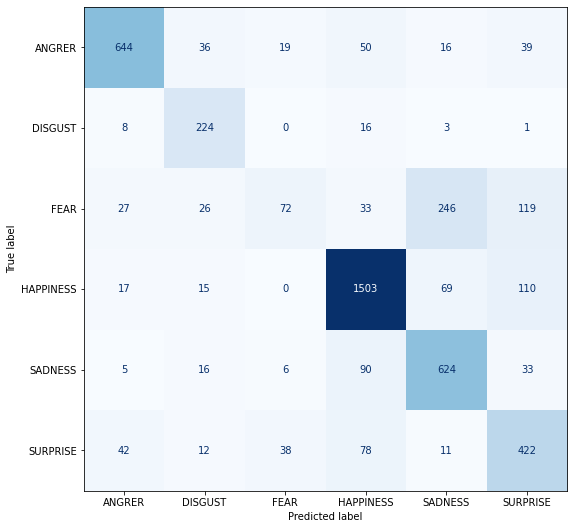

In [32]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
def plt_conf_matrix(y_true,y_pred,filename=None):
    print(y_pred.shape,y_true.shape, (y_pred==y_true).mean())

    fig, ax = plt.subplots(figsize=(8, 8))
    #plot_confusion_matrix(IC, y_pred,y_true,display_labels=['0','0.33','0.66','1'],cmap=plt.cm.Blues,ax=ax) #,normalize='true'
    plot_confusion_matrix(IC, y_pred,y_true,display_labels=list(idx_to_class.values()),cmap=plt.cm.Blues,ax=ax,colorbar=False) #,normalize='true'
    plt.tight_layout()
    plt.show()
plt_conf_matrix(y_val,y_pred)

enet0_vgaf
pre-trained
65.78158458244111
(0.5934796285071012, 0.6578158458244111, [0.7771124417831005, 0.6078184110970996, 0.16384915474642392, 0.8159303882195447, 0.6519083969465649, 0.5442589782498735])


finetuned
73.85438972162741
(0.654354139057469, 0.7385438972162741, [0.8022813688212929, 0.7804878048780488, 0.11182108626198083, 0.8706921944035346, 0.7078099399235391, 0.6530324400564175])


other - enet0_vgaf_synth
f1 0.61
64.26124197002142
(0.588025705476551, 0.6426124197002141, [0.7812709030100333, 0.704, 0.18242491657397109, 0.8293471234647706, 0.515230635335074, 0.5158806544754572])
ANGRER acc: 72.636816
DISGUST acc: 87.301587
FEAR acc: 15.678776
HAPPINESS acc: 74.854142
SADNESS acc: 38.242894
SURPRISE acc: 88.888889

finetuned
73.31905781584582
(0.6490162649017471, 0.7331905781584582, [0.7989347536617843, 0.783132530120482, 0.1199400299850075, 0.8785933575216299, 0.6816431322207959, 0.6318537859007832])
ANGRER acc: 74.626866
DISGUST acc: 77.380952
FEAR acc: 7.648184
HAPPINESS acc: 91.831972
SADNESS acc: 68.604651
SURPRISE acc: 80.265340


SR: enet0_vgaf_synth_sr
65.80299785867237
(0.6063618790046222, 0.6580299785867237, [0.7800882167611847, 0.6826516220028208, 0.21616161616161617, 0.8252714708785786, 0.5852534562211982, 0.5487448920023351])
ANGRER acc: 76.990050
DISGUST acc: 96.031746
FEAR acc: 20.458891
HAPPINESS acc: 73.162194
SADNESS acc: 49.224806
SURPRISE acc: 77.943615

finetuned
73.66167023554604
(0.6674443847218857, 0.7366167023554604, [0.8130718954248366, 0.7806563039723663, 0.17678100263852242, 0.8706022659511031, 0.7361809045226132, 0.627373935821873])
ANGRER acc: 77.363184
DISGUST acc: 89.682540
FEAR acc: 12.810707
HAPPINESS acc: 85.180863
SADNESS acc: 75.710594
SURPRISE acc: 79.436153


SR+augmentation
63.70449678800856
(0.5993702871581568, 0.6370449678800857, [0.7980965329707681, 0.6246786632390745, 0.25539906103286386, 0.7794117647058824, 0.6091228070175438, 0.529512893982808])
finetuned
73.83297644539614
(0.6718416735225636, 0.7383297644539615, [0.8289473684210528, 0.819614711033275, 0.18579234972677597, 0.8821385176184691, 0.705120659211301, 0.6094364351245085])

pretraind weights:
(0.5972238146661198, 0.6659528907922913, [0.6810089020771514, 0.5446685878962535, 0.2121212121212121, 0.8410789730256744, 0.6822429906542056, 0.6222222222222221])
finetuned:
(0.6630533078741039, 0.7254817987152035, [0.8121059268600253, 0.7950089126559715, 0.18585298196948682, 0.8482932996207332, 0.6940494997367035, 0.6430092264017033])

rmsprop synth sr
(0.5728653818870095, 0.6117773019271948, [0.784625579854208, 0.6392572944297082, 0.1774042950513539, 0.7675485008818342, 0.5535574667709148, 0.5147991543340381])

finetuned
73.25481798715204
(0.6612836822606303, 0.7325481798715203, [0.7961826857532379, 0.8028169014084506, 0.14641288433382138, 0.8691878487290762, 0.7387978142076503, 0.6143039591315453])


mtl
(0.6198286464927475, 0.6702355460385439, [0.7741496598639457, 0.6177606177606177, 0.31215970961887485, 0.8359960873818063, 0.6494512588766946, 0.5294545454545455])
ANGRER acc: 70.771144
DISGUST acc: 95.238095
FEAR acc: 32.887189
HAPPINESS acc: 74.795799
SADNESS acc: 64.987080
SURPRISE acc: 60.364842

finetuned
(0.6728896450510998, 0.7471092077087794, [0.832579185520362, 0.7710843373493975, 0.2188449848024316, 0.8628013777267509, 0.7160068846815835, 0.6360211002260738])
ANGRER acc: 80.099502
DISGUST acc: 88.888889
FEAR acc: 13.766730
HAPPINESS acc: 87.689615
SADNESS acc: 80.620155
SURPRISE acc: 69.983416

mtl orig (no SR)
(0.6110638230564416, 0.6918629550321199, [0.7706666666666667, 0.6554621848739496, 0.17326732673267325, 0.8649282156460593, 0.6015037593984962, 0.6005547850208045])
finetuned
(0.6324464232527586, 0.7267665952890793, [0.78397898883782, 0.6938775510204083, 0.11128775834658187, 0.8548168249660787, 0.6708307307932543, 0.6798866855524079])


tta
72.20556745182013
(0.626916572476696, 0.7220556745182013, [0.8007312614259596, 0.7290076335877862, 0.08077544426494344, 0.8729698375870069, 0.6551083591331269, 0.6229068988613531])


no SAM
63.25481798715204
(0.5828531728429681, 0.6325481798715203, [0.7791005291005291, 0.6920821114369501, 0.22175290390707497, 0.8043478260869564, 0.46938775510204084, 0.5304479114242577])

finetuned
73.81156316916488
(0.6632949616250127, 0.7381156316916488, [0.7873910127431253, 0.7841584158415842, 0.18448023426061494, 0.870848708487085, 0.6990179087232814, 0.6538734896943851])



112x112
56.42398286937902
(0.5076140416761095, 0.5642398286937902, [0.6253644314868805, 0.526896551724138, 0.35036496350364965, 0.7487593052109182, 0.3326848249027237, 0.4616141732283465])


finetuned
68.8865096359743
(0.607469077914598, 0.688865096359743, [0.7378917378917379, 0.7009966777408637, 0.11940298507462688, 0.8447717231222387, 0.6411543287327478, 0.6005970149253731])




class_weights:
73.94004282655246
(0.6582644236257021, 0.7394004282655247, [0.7997320830542531, 0.7231638418079096, 0.18707015130674004, 0.8734559429041998, 0.6773809523809524, 0.6887835703001579])
ANGRER acc: 74.253731
DISGUST acc: 76.190476
FEAR acc: 13.001912
HAPPINESS acc: 92.823804
SADNESS acc: 73.514212
SURPRISE acc: 72.305141

finetuned
74.23982869379014
(0.6460185636537498, 0.7423982869379016, [0.8089005235602096, 0.6845637583892618, 0.10591900311526481, 0.8659217877094972, 0.7168000000000001, 0.694006309148265])
ANGRER acc: 76.865672
DISGUST acc: 60.714286
FEAR acc: 6.500956
HAPPINESS acc: 90.431739
SADNESS acc: 86.821705
SURPRISE acc: 72.968491




enet0_afew
65.61027837259101
(0.5979312204512576, 0.65610278372591, [0.7397959183673469, 0.7122861586314151, 0.21166306695464365, 0.8321853475266124, 0.5216680294358136, 0.5699888017917133])


finetuned
71.77730192719486
(0.6274366335531597, 0.7177730192719486, [0.8027043638598648, 0.7861060329067641, 0.041666666666666664, 0.8615937687237868, 0.6570713391739674, 0.6154776299879082])



enet_b2_8
67.21627408993577
(0.5988878018248252, 0.6721627408993576, [0.7120055517002082, 0.6804451510333863, 0.1659634317862166, 0.8386308068459658, 0.6202450032237267, 0.5760368663594471])

finetuned
73.08351177730192
(0.6411837846751335, 0.7308351177730192, [0.7857142857142856, 0.707165109034268, 0.12824427480916029, 0.8810232004759072, 0.6738148984198645, 0.6711409395973154])

--------------

In [22]:
#FT_PATH = "enet0_vgaf_synth.pt" #0.6460185636537498, 0.7423982869379016
#FT_PATH = "enet0_vgaf_synth_sr.pt" #(0.6718416735225636, 0.7383297644539615

#FT_PATH = "enet0_mtl_synth_sr_head.pt" #0.6198286464927475, 0.6702355460385439
FT_PATH = "enet0_mtl_synth_sr.pt" #(0.6728896450510998, 0.7471092077087794

FT_PATH='../../../emotions-multimodal/faces/ABAW/abaw4/'+FT_PATH
print(FT_PATH)

../../../emotions-multimodal/faces/ABAW/abaw4/enet0_mtl_synth_sr.pt


In [49]:
# Save
if False:
    torch.save(model, FT_PATH)

In [23]:
# Load
print(FT_PATH)
model = torch.load(FT_PATH)

../../../emotions-multimodal/faces/ABAW/abaw4/enet0_mtl_synth_sr.pt


# Ensemble

In [26]:
for w in np.linspace(0,1,11):
    y_ensemble=w*y_scores_val_filtered+(1-w)*y_scores_val
    y_pred=np.argmax(y_ensemble,axis=1)
    acc=100.0*(y_val==y_pred).sum()/len(y_val)
    print(w,metric_for_Exp(gt=y_val,pred=y_pred))

0.0 (0.6728896450510998, 0.7471092077087794, [0.832579185520362, 0.7710843373493975, 0.2188449848024316, 0.8628013777267509, 0.7160068846815835, 0.6360211002260738])
0.1 (0.6758221559080676, 0.7511777301927195, [0.8311688311688312, 0.759535655058043, 0.2225519287833828, 0.8701449275362318, 0.7286202964652224, 0.6429112964366945])
0.2 (0.6804378545375007, 0.7556745182012848, [0.8302872062663186, 0.755700325732899, 0.22575976845151954, 0.8756218905472638, 0.7447651386530842, 0.6504927975739195])
0.30000000000000004 (0.6818314932370502, 0.7569593147751607, [0.8257725180802103, 0.750402576489533, 0.22562674094707522, 0.8834319526627219, 0.7501410039481106, 0.6556141672946496])
0.4 (0.6808765627315276, 0.7550321199143469, [0.827037773359841, 0.7312500000000001, 0.23324396782841825, 0.8840970350404312, 0.7519729425028184, 0.6576576576576576])
0.5 (0.6767668912840116, 0.7505353319057816, [0.8176943699731903, 0.7158218125960062, 0.23146944083224963, 0.8839745531657073, 0.7519553072625699, 0.65

pre-trained:
1.0 (0.5972238146661198, 0.6659528907922913, [0.6810089020771514, 0.5446685878962535, 0.2121212121212121, 0.8410789730256744, 0.6822429906542056, 0.6222222222222221])

ensemble:
"enet0_vgaf_synth.pt" #0.6460185636537498, 0.7423982869379016
0.0 (0.6466857196469123, 0.7406852248394005, [0.7997293640054127, 0.7587476979742174, 0.07886435331230283, 0.8817927170868348, 0.7117008443908324, 0.6492793411118737])
0.2 (0.6742077497457526, 0.7578158458244111, [0.8094594594594595, 0.7849829351535835, 0.1402002861230329, 0.9014248328002326, 0.7410817031070196, 0.6680972818311874])

enet0_vgaf_synth_sr
old
0.0 (0.6674443847218857, 0.7366167023554604, [0.8130718954248366, 0.7806563039723663, 0.17678100263852242, 0.8706022659511031, 0.7361809045226132, 0.627373935821873])
0.2 (0.6787264171576318, 0.7492505353319058, [0.8160843770599868, 0.7573770491803279, 0.20512820512820515, 0.8841149773071104, 0.7531231409875074, 0.6565307532826538])

latest
0.0 (0.6718416735225636, 0.7383297644539615, [0.8289473684210528, 0.819614711033275, 0.18579234972677597, 0.8821385176184691, 0.705120659211301, 0.6094364351245085])
0.30000000000000004 (0.6845951242198453, 0.7486081370449679, [0.8215712383488681, 0.7845117845117845, 0.22415940224159403, 0.8865598027127004, 0.7293064876957494, 0.6614620298083748])

enet0_mtl_synth_sr
0.0 (0.6728896450510998, 0.7471092077087794, [0.832579185520362, 0.7710843373493975, 0.2188449848024316, 0.8628013777267509, 0.7160068846815835, 0.6360211002260738])
0.30000000000000004 (0.6818314932370502, 0.7569593147751607, [0.8257725180802103, 0.750402576489533, 0.22562674094707522, 0.8834319526627219, 0.7501410039481106, 0.6556141672946496])

enet0_mtl np sr
0.0 (0.6324464232527586, 0.7267665952890793, [0.78397898883782, 0.6938775510204083, 0.11128775834658187, 0.8548168249660787, 0.6708307307932543, 0.6798866855524079])
0.4 (0.6675524629718682, 0.7524625267665953, [0.8021319120586274, 0.7133333333333333, 0.16759776536312848, 0.8931074766355139, 0.7254672897196262, 0.7036770007209805])

Pre-trained
(0.6094158203574996, 0.6882226980728051, [0.7262569832402234, 0.5073313782991203, 0.23831775700934577, 0.8456375838926175, 0.7091004734350342, 0.6298507462686567])
(4670,) (4670,) 0.6882226980728051


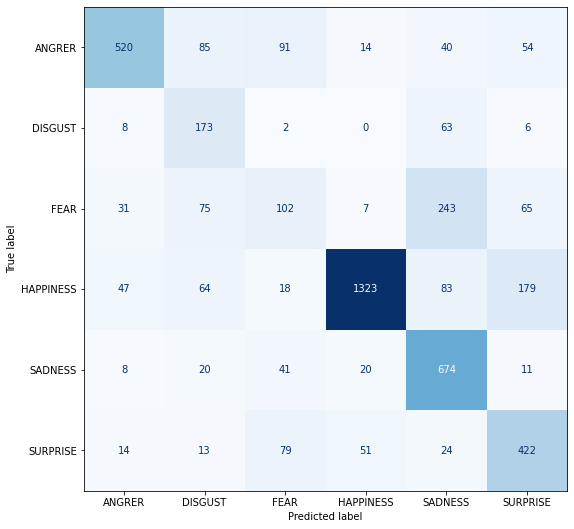

In [36]:
print('Pre-trained')
y_pred=np.argmax(y_scores_val_filtered,axis=1)
print(metric_for_Exp(gt=y_val,pred=y_pred))
plt_conf_matrix(y_val,y_pred)

Ensemble
(0.6818314932370502, 0.7569593147751607, [0.8257725180802103, 0.750402576489533, 0.22562674094707522, 0.8834319526627219, 0.7501410039481106, 0.6556141672946496])
(4670,) (4670,) 0.7569593147751607


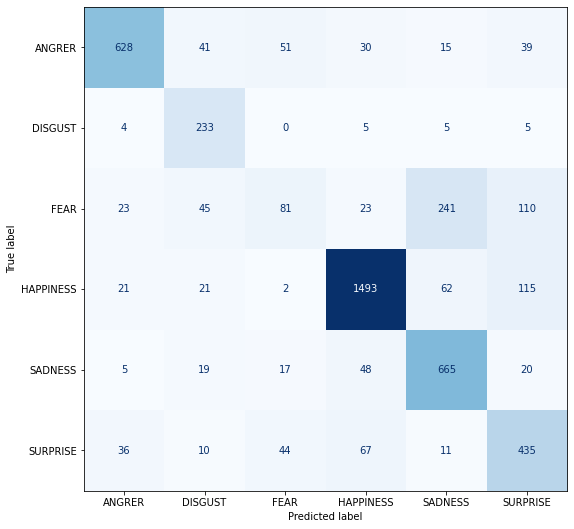

In [35]:
print('Ensemble')
w=0.3
y_ensemble=w*y_scores_val_filtered+(1-w)*y_scores_val
y_pred=np.argmax(y_ensemble,axis=1)
print(metric_for_Exp(gt=y_val,pred=y_pred))
plt_conf_matrix(y_val,y_pred)

# Test set results

In [36]:
with open(os.path.join(DATA_DIR,'LSD_Challenge_test_set_release.txt'),'r') as f:
    test_set_images=f.read().splitlines()
print(len(test_set_images),test_set_images[:5])

106121 ['image,expression', '0.jpg', '1.jpg', '2.jpg', '3.jpg']


In [48]:
model.eval()

y_pred_test=[]
imgs=[]
for img_name in tqdm(test_set_images[1:]):
    if img_name.lower().endswith('.jpg'):
        filepath=final_test_dir / img_name
        img = Image.open(filepath)
        img_tensor = test_transforms(img)
        if img.size:
            imgs.append(img_tensor)
            if len(imgs)>=64: #96: #48: #32:
                imgs=torch.stack(imgs, dim=0).to(device)
                scores = model(imgs)
                scores=scores.data.cpu().numpy()

                if len(y_pred_test)==0:
                    y_pred_test=scores
                else:
                    y_pred_test=np.concatenate((y_pred_test,scores),axis=0)
                imgs=[]

if len(imgs)>0:        
    imgs=torch.stack(imgs, dim=0).to(device)
    scores = model(imgs)
    scores=scores.data.cpu().numpy()

    if len(y_pred_test)==0:
        y_pred_test=scores
    else:
        y_pred_test=np.concatenate((y_pred_test,scores),axis=0)

print(y_pred_test.shape)

  0%|          | 0/106120 [00:00<?, ?it/s]

(106120, 6)


In [38]:
y_pred_test_pretrained=[]
pretrained_model.eval()

imgs=[]
for img_name in tqdm(test_set_images[1:]):
    if img_name.lower().endswith('.jpg'):
        filepath=final_test_dir / img_name
        img = Image.open(filepath)
        img_tensor = test_transforms(img)
        if img.size:
            imgs.append(img_tensor)
            if len(imgs)>=64: #96: #48: #32:
                imgs=torch.stack(imgs, dim=0).to(device)
                scores_pretrained = pretrained_model(imgs)
                scores_pretrained=scores_pretrained.data.cpu().numpy()
                
                if len(y_pred_test_pretrained)==0:
                    y_pred_test_pretrained=scores_pretrained
                else:
                    y_pred_test_pretrained=np.concatenate((y_pred_test_pretrained,scores_pretrained),axis=0)
                imgs=[]

if len(imgs)>0:        
    imgs=torch.stack(imgs, dim=0).to(device)
    scores_pretrained = pretrained_model(imgs)
    scores_pretrained=scores_pretrained.data.cpu().numpy()

    if len(y_pred_test_pretrained)==0:
        y_pred_test_pretrained=scores_pretrained
    else:
        y_pred_test_pretrained=np.concatenate((y_pred_test_pretrained,scores_pretrained),axis=0)

print(y_pred_test_pretrained.shape)

  0%|          | 0/106120 [00:00<?, ?it/s]

(106120, 10)


In [39]:
resdir=DATA_DIR /'test_results/LSD'
if not os.path.exists(resdir):
    os.makedirs(resdir)
header = 'image,expression\n'

In [40]:
y_scores_test_filtered=y_pred_test_pretrained[:, indices]
print(y_scores_test_filtered.shape)
y_expr=np.argmax(y_scores_test_filtered,axis=1)
print(y_expr.shape)

with open(os.path.join(resdir,'1_preds_pretrained.txt'), 'w') as f:
    f.write(header)
    for i in range(len(y_pred_test_pretrained)):
        s=test_set_images[i+1]+','+str(y_expr[i])+'\n'
        f.write(s)

(106120, 6)
(106120,)


In [41]:
y_expr=np.argmin(y_pred_test,axis=1)
print(y_expr.shape)
with open(os.path.join(resdir,'2_preds_finetuned_head.txt'), 'w') as f: #'4_preds_finetuned_all.txt'
    f.write(header)
    for i in range(len(y_pred_test_pretrained)):
        s=test_set_images[i+1]+','+str(y_expr[i])+'\n'
        f.write(s)

(106120,)


In [42]:
w=0.5
y_scores_test_filtered=y_pred_test_pretrained[:, indices]
print(y_scores_test_filtered.shape)
y_ensemble=w*y_scores_test_filtered+(1-w)*y_pred_test
y_expr=np.argmax(y_ensemble,axis=1)
print(y_expr.shape)

with open(os.path.join(resdir,'3_preds_ensemble_head.txt'), 'w') as f: #'5_preds_ensemble_all.txt'
    f.write(header)
    for i in range(len(y_pred_test_pretrained)):
        s=test_set_images[i+1]+','+str(y_expr[i])+'\n'
        f.write(s)

(106120, 6)
(106120,)
